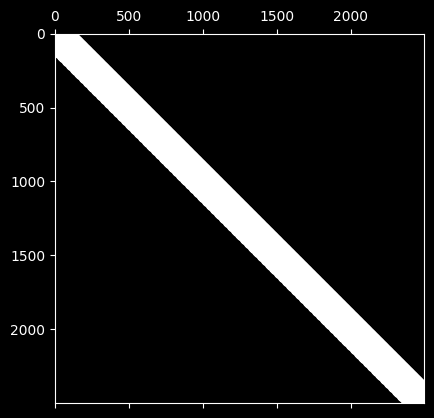

In [3]:
#8.6
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def arnoldi(A, u, m):
    n = A.shape[0]
    Q = np.zeros([n, m + 1])
    H = np.zeros([m + 1, m])
    Q[:, 0] = u / np.linalg.norm(u)

    for i in range(m):
        v =  A @ Q[:, i]

        for j in range(i + 1):
            H[j, i] = Q[:, j] @ v
            v -= H[j, i] * Q[:, j]

        H[i + 1, i] = np.linalg.norm(v)
        Q[:, i + 1] = v / H[i + 1, i]

    return Q, H

def gmres(A, b, m):
    Q, H = arnoldi(A, b, m)
    e1 = np.linalg.norm(b) * np.hstack((np.ones(1), np.zeros(m)))
    z = np.linalg.lstsq(H, e1, rcond=None)[0]
    x = Q[:, :-1] @ z

    return x

def poisson_2d(n):
    """
    构造二维 n*n 网格的离散拉普拉斯矩阵 A (大小 n^2 * n^2)
    这对应于 FNC.poisson(n)
    """
    # 1. 构造一维的算子 T (三对角矩阵)
    # 大小 n * n
    # 这里的 2 和 -1 是数学上的拓扑关系，物理参数(质量/张力)可以在外部乘上去
    data = [np.ones(n)*2, np.ones(n-1)*-1, np.ones(n-1)*-1]
    offsets = [0, 1, -1]
    T = sp.sparse.diags(data, offsets, shape=(n, n), format='csr')

    # 2. 利用 Kronecker Sum 扩展到二维
    # A = T ⊕ T
    # k = 1 (上下左右四个邻居)
    A = sp.sparse.kronsum(T, T, format='csr')

    return A

d = 50;  n = d**2
A = poisson_2d(d)
b = np.ones(n)
plt.spy(A);


In [5]:
#8.6.1
import numpy as np
import scipy as sp

def arnoldi(A, u, m):
    n = A.shape[0]
    Q = np.zeros([n, m + 1])
    H = np.zeros([m + 1, m])
    Q[:, 0] = u / np.linalg.norm(u)

    for i in range(m):
        v =  A @ Q[:, i]

        for j in range(i + 1):
            H[j, i] = Q[:, j] @ v
            v -= H[j, i] * Q[:, j]

        H[i + 1, i] = np.linalg.norm(v)
        if np.linalg.norm(v) < 1e-12:
            break;

        Q[:, i + 1] = v / H[i + 1, i]

    return Q, H

def gmres(A, b, m):
    Q, H = arnoldi(A, b, m)
    e1 = np.linalg.norm(b) * np.hstack((np.ones(1), np.zeros(m)))
    z = np.linalg.lstsq(H, e1, rcond=None)[0]
    x = Q[:, :-1] @ z

    return x

A = np.array([
    [0., 1., 0., 0.],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [1., 0., 0., 0.]
])

b = np.zeros(4)
b[0] = 1
m = range(1, 5)
x = []
for i in m:
    x.append(gmres(A, b, i))

print(x)

[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 1., 0., 0.])]


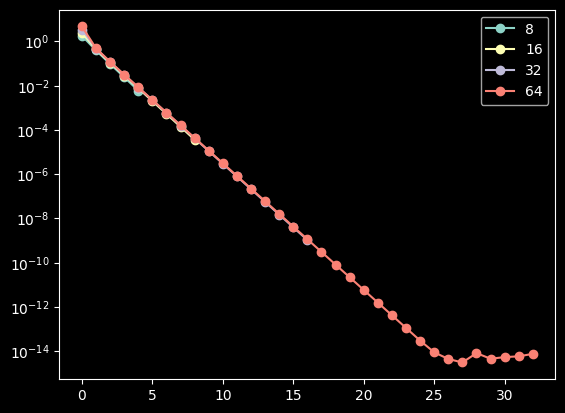

In [13]:
#8.5.4
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def gmres(A, b, m):

    n = len(b)
    Q = np.zeros([n, m + 1])
    Q[:, 0] = b / np.linalg.norm(b)
    H = np.zeros([m + 1, m])

    residual = np.hstack([np.linalg.norm(b), np.zeros(m)])

    for j in range(m):

        v = A @ Q[:, j]
        for i in range(j + 1):
            H[i, j] = Q[:, i] @ v
            v -= H[i, j] * Q[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        Q[:, j + 1] = v / H[j + 1, j]

        r = np.hstack([np.linalg.norm(b), np.zeros(j + 1)])
        z = np.linalg.lstsq(H[:j + 2, :j + 1], r)[0]
        x = Q[:, :j + 1] @ z
        residual[j + 1] = np.linalg.norm(A @ x - b)

    return x, residual

n = np.array([8, 16, 32, 64])
#plt.subplots()
for i in n:
    m = i // 2
    b = [k / i for k in range(1, i + 1)]
    data = [np.ones(i - 1), -4 * np.ones(i), np.ones(i - 1)]
    offset = [-1, 0, 1]
    A = sp.sparse.diags(data, offset, format='lil')
    x, residual = gmres(A, b, m)
    plt.semilogy(np.arange(m + 1), residual, "-o")
    plt.grid()
    plt.legend(["8", "16", "32", "64"])

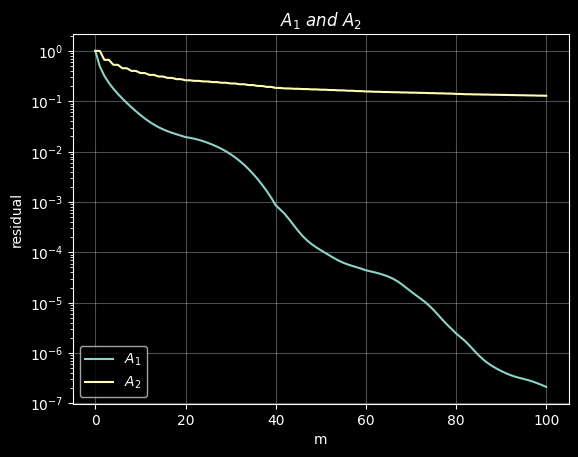

In [14]:
#8.5.5
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

ev = np.arange(1, 101)
b = np.ones(200)
B = sp.sparse.diags(ev, format='lil')
I = sp.sparse.eye(100)
Z = sp.sparse.csr_matrix((100, 100))
A_1 = sp.sparse.bmat([
    [B, I],
    [Z, B]
], format='csr')
A_2 = sp.sparse.bmat([
    [B, I],
    [Z, -B]
], format='csr')

tol = 1e-10
maxit = 100
residual_1 = [1.]
hist = lambda rvec: residual_1.append(np.linalg.norm(rvec))
x, flag = sp.sparse.linalg.gmres(A_1, b, restart=None, rtol=tol, atol=tol, maxiter=maxit, callback=hist)
plt.semilogy(residual_1)

residual_2 = [1.]
hist = lambda rvec: residual_2.append(np.linalg.norm(rvec))
x, flag = sp.sparse.linalg.gmres(A_2, b, restart=None, rtol=tol, atol=tol, maxiter=maxit, callback=hist)
plt.semilogy(residual_2)

plt.title(r"$A_1 \ and \ A_2$")
plt.xlabel("m"), plt.ylabel("residual")
plt.legend([r"$A_1$", r"$A_2$"], loc='lower left')
plt.grid(True, ls="-", alpha=0.3)

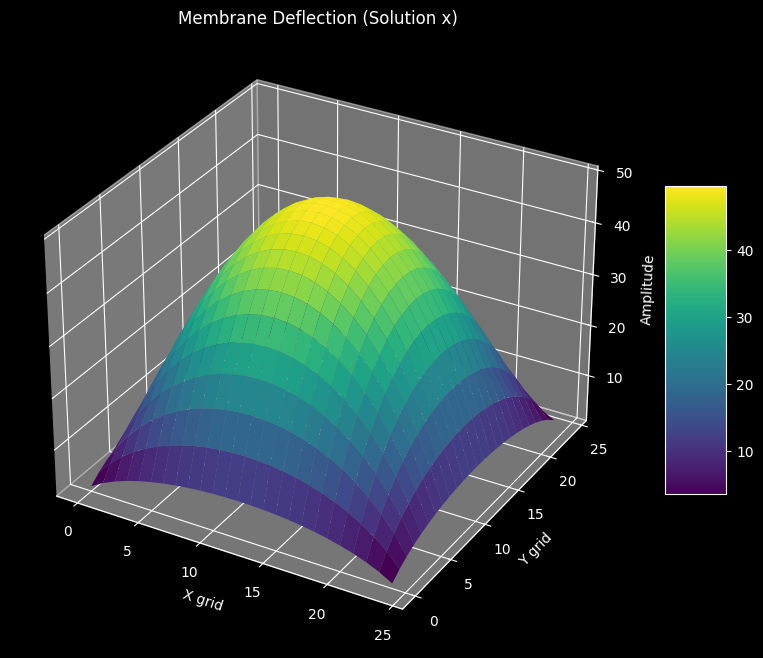

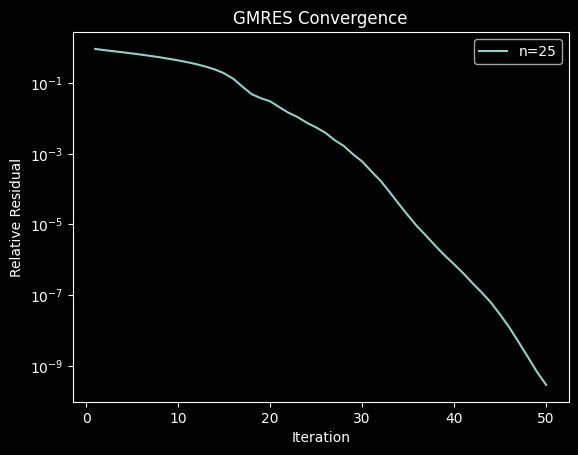

In [5]:
#8.5.6
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def poisson_2d(n):
    """
    构造二维 n*n 网格的离散拉普拉斯矩阵 A (大小 n^2 * n^2)
    这对应于 FNC.poisson(n)
    """
    # 1. 构造一维的算子 T (三对角矩阵)
    # 大小 n * n
    # 这里的 2 和 -1 是数学上的拓扑关系，物理参数(质量/张力)可以在外部乘上去
    data = [np.ones(n)*2, np.ones(n-1)*-1, np.ones(n-1)*-1]
    offsets = [0, 1, -1]
    T = sp.sparse.diags(data, offsets, shape=(n, n), format='csr')

    # 2. 利用 Kronecker Sum 扩展到二维
    # A = T ⊕ T
    # k = 1 (上下左右四个邻居)
    A = sp.sparse.kronsum(T, T, format='csr')

    return A

def gmres(A, b, m):

    n = len(b)
    Q = np.zeros([n, m + 1])
    Q[:, 0] = b / np.linalg.norm(b)
    H = np.zeros([m + 1, m])

    residual = np.hstack([np.linalg.norm(b), np.zeros(m)])

    for j in range(m):

        v = A @ Q[:, j]
        for i in range(j + 1):
            H[i, j] = Q[:, i] @ v
            v -= H[i, j] * Q[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        Q[:, j + 1] = v / H[j + 1, j]

        r = np.hstack([np.linalg.norm(b), np.zeros(j + 1)])
        z = np.linalg.lstsq(H[:j + 2, :j + 1], r)[0]
        x = Q[:, :j + 1] @ z
        residual[j + 1] = np.linalg.norm(A @ x - b)

    return x, residual
i = 25

#准备矩阵和向量
A = poisson_2d(i) # 假设你定义了这个函数
b = np.ones(i**2)
b_norm = np.linalg.norm(b)

history = []

steps = range(1, 51) # [1, 2, ..., 50]

for k in steps:
    # 调用 gmres 计算第 k 步的解
    # 注意：这里我们每次都从头算到 k，这在你目前的函数写法下是必须的
    x, _ = gmres(A, b, k)

    # 计算当前步的残差并存起来
    r_curr = b - A @ x
    history.append(np.linalg.norm(r_curr) / b_norm)


Z = x.reshape(n, n)

x_axis = np.arange(n)
y_axis = np.arange(n)
X, Y = np.meshgrid(x_axis, y_axis)

#绘制 3D 表面图
fig = plt.figure(figsize=(10, 8))       # 创建一个画布
ax = fig.add_subplot(111, projection='3d') # 添加一个3D坐标轴

# X, Y: 地面上的网格坐标
# Z:    高度数据
# cmap: 颜色映射 (viridis 是常用的蓝-黄渐变，很适合表示高低)
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# 添加旁边的颜色条，用来参照数值大小
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# 设置标题和标签
ax.set_title(f"Membrane Deflection (Solution x)")
ax.set_xlabel("X grid")
ax.set_ylabel("Y grid")
ax.set_zlabel("Amplitude")

plt.show()


plt.semilogy(steps, history, label=f'n={i}')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Relative Residual')
plt.title('GMRES Convergence')
plt.show()
